(c) 2021, Franz Ludwig Kostelezky, IMTEK chair of simulation, \<info@kostelezky.com\>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import lfilter, butter
from itertools import product

In [2]:
import reconstructionutils as ru
import cutility as cu

In [3]:
# import multichannel ecg data by R.Moss
data = pd.read_csv('./ECG_data/moss/MeasuredECG.txt', sep=" ", header=1)
data.columns = ['time', 'E1', 'E2', 'E3', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

In [4]:
# since there is an offset between s[0] and s[-1] one needs to manipulate
# the series that is is truly periodical. this is achieved by tilting the series
tilt_series = lambda t, z: z[t] - (z[-1] - z[0]) * t / len(z)

In [5]:
# original time series
# selected by correlation analysis
z_1_original = np.array(data['E1'])
z_2_original = np.array(data['W3'])
z_3_original = np.array(data['W4'])

timesteps_ = data['time']

In [6]:
# procedure:
# 1. tilt the series, make it full periodical
# 2. filter the series, lowpass filter
# 3. add offset to each series
# 4. tilt it the second time
# 5. cut into intervals

In [7]:
# 1. tilt
z_1_periodical = tilt_series(np.arange(0, len(z_1_original)), z_1_original)
z_2_periodical = tilt_series(np.arange(0, len(z_2_original)), z_2_original)
z_3_periodical = tilt_series(np.arange(0, len(z_3_original)), z_3_original)

In [8]:
# 2. filter the signals with a lowpass to remove unwanted jitter
b, a = butter(3, .01)  # 0.83 cutoff -> 50 Hz, .0415 -> 25 Hz, 0.027 -> ca. 16 Hz

z_1_filtered = lfilter(b, a, z_1_periodical)
z_2_filtered = lfilter(b, a, z_2_periodical)
z_3_filtered = lfilter(b, a, z_3_periodical)

In [9]:
# 3. add offset
z_1_filtered += 0
z_2_filtered += -1e-1
z_3_filtered += 1e-1

In [10]:
# 4. second time tilting
z_1_ = tilt_series(np.arange(0, len(z_1_filtered)), z_1_filtered)
z_2_ = tilt_series(np.arange(0, len(z_2_filtered)), z_2_filtered)
z_3_ = tilt_series(np.arange(0, len(z_3_filtered)), z_3_filtered)

In [11]:
z_1_derivate_full = cu.first_order_upwind(z_1_)
z_2_derivate_full = cu.first_order_upwind(z_2_)
z_3_derivate_full = cu.first_order_upwind(z_3_)

series_full = [z_1_, z_2_, z_3_]
series_derivate_full = [z_1_derivate_full, z_2_derivate_full, z_3_derivate_full]

In [12]:
intervals = [(0, 160),
             (160, 280),
             (280, 300),
             (300, 380),
             (380, 470),
             (470, 520),
             (520, 570),
             (570, -1),
            ]  # (min, max)

series_intervals = []
for i in range(len(intervals)):
    li, gi = intervals[i]
    series_intervals.append([[
                              z_1_[li:gi],
                              z_2_[li:gi],
                              z_3_[li:gi],
                             ],
                             [
                              z_1_derivate_full[li:gi],
                              z_2_derivate_full[li:gi],
                              z_3_derivate_full[li:gi],
                             ],
                             timesteps_[li:gi],
                            ]
                           )

<IPython.core.display.Javascript object>


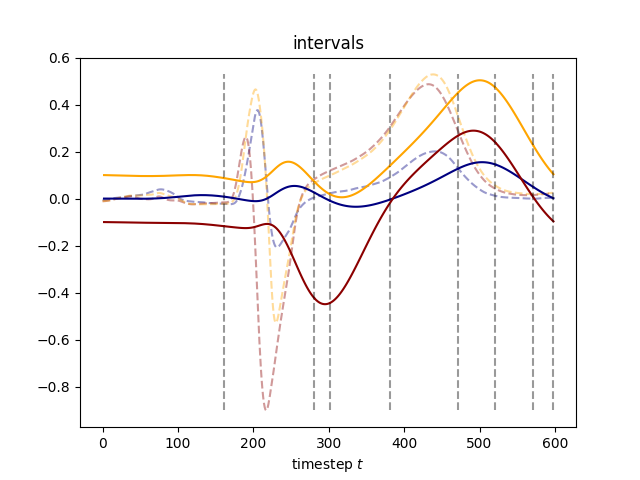

In [13]:
%matplotlib notebook
plt.title('intervals')
plt.plot(z_1_original, c='navy', linestyle='--', alpha=.4, label='$z_1$ original')
plt.plot(z_2_original, c='darkred', linestyle='--', alpha=.4, label='$z_2$ original')
plt.plot(z_3_original, c='orange', linestyle='--', alpha=.4, label='$z_3$ original')

for i in range(len(series_intervals)):
    el = series_intervals[i]
    series = el[0]
    
    plt.plot(el[2], series[0], c='navy', label='$z_1$ interval %i' % (i))
    plt.plot(el[2], series[1], c='darkred', label='$z_2$ interval %i' % (i))
    plt.plot(el[2], series[2], c='orange', label='$z_3$ interval %i' % (i))
    
    plt.plot([list(el[2])[-1], list(el[2])[-1]], [np.min(z_2_original), np.max(z_3_original)], 
             c='black', alpha=.4, linestyle='--')

#plt.legend()
plt.xlabel('timestep $t$')
plt.show()

In [14]:
grade = 4

In [15]:
models = []

for i in range(len(series_intervals)):
    series = series_intervals[i][0]
    series_derivate = series_intervals[i][1]
    series_timeframe = list(series_intervals[i][2])

    f = 1024
    reconstruction_timeframe = np.linspace(series_timeframe[0], series_timeframe[-1], len(series_timeframe) * f)
    
    system = ru.Model(series, grade=grade, derivate=series_derivate)
    res = system.evaluate()
    
    models.append([
                   system,
                   series_timeframe,
                   reconstruction_timeframe,
                  ])

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


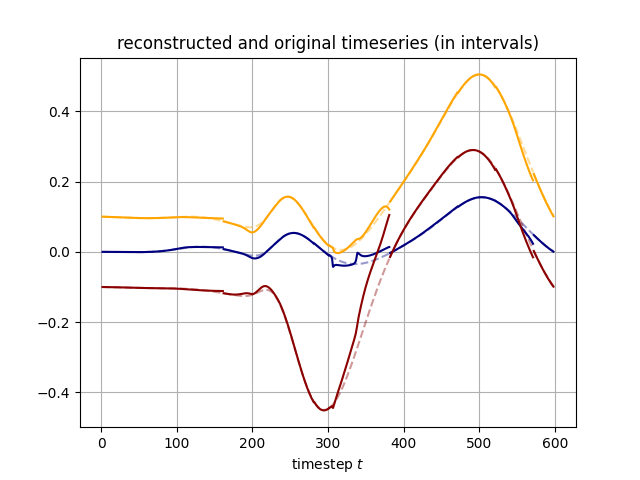

In [16]:
%matplotlib notebook
for el in models:
    plt.plot(el[1], el[0].series[0], linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
    plt.plot(el[1], el[0].series[1], linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
    plt.plot(el[1], el[0].series[2], linestyle='--', alpha=.4, label='$z_3$ original', c='orange')

    plt.plot(el[2], el[0].solution.T[0], label='$z_1$ reconstructed', c='navy')
    plt.plot(el[2], el[0].solution.T[1], label='$z_2$ reconstructed', c='darkred')
    plt.plot(el[2], el[0].solution.T[2], label='$z_3$ reconstructed', c='orange')

plt.title('reconstructed and original timeseries (in intervals)')
plt.xlabel('timestep $t$')
plt.grid()

#plt.legend()
plt.show()

In [17]:
t = np.linspace(0, len(z_1_original), 2000)

In [29]:
gamma = []

epsilon = .5  # below gamma shall return 0

for i in range(len(intervals)):
    li = intervals[i][0]
    gi = intervals[i][1]

    if gi == -1:
        gi = len(z_1_original) + 100
    if li == 0:
        li = -100

    o = (np.arctan(t - li) - np.arctan(t - gi))
    o_max = np.max(o)


    def _1(t, i=i, li=li, gi=gi, o_max=o_max):
        #tmp = (np.arctan(t - li) - np.arctan(t - gi)) / o_max
        #return tmp * (tmp > epsilon)
        
        return t * (li <= t <= gi)
    
    gamma.append(_1)

<IPython.core.display.Javascript object>


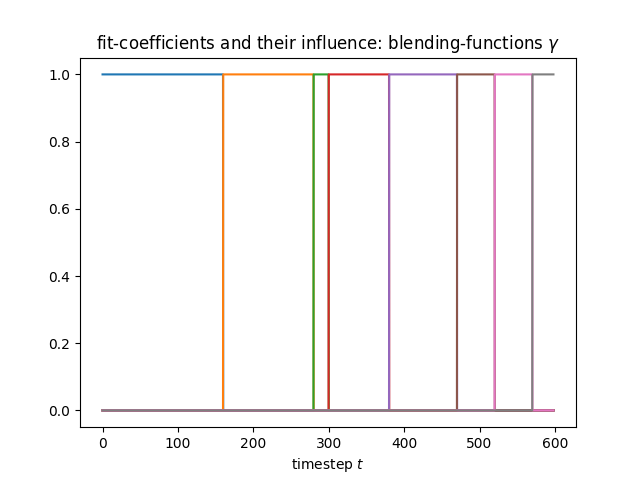

In [19]:
%matplotlib notebook
for el in gamma:
    plt.plot(t, el(t))
plt.title('fit-coefficients and their influence: blending-functions $\gamma$')
plt.xlabel('timestep $t$')
plt.show()

In [25]:
time_dependent_fit_coefficients = [[], [], []]


for i in range(len(models[0][0].fit_coefficients)):  # 3: p,q,r
    for j in range(len(models[0][0].fit_coefficients[i])):  # 34: p_0, ..., p_33
        #print(j)
        def _2(t, i=i, j=j):
            res = 0
            for k in range(len(gamma)):  # 8
                #print(i, j, k, np.shape(res))
                res += gamma[k](t) * models[k][0].fit_coefficients[i][j]
            return res
        time_dependent_fit_coefficients[i].append(_2)

<IPython.core.display.Javascript object>


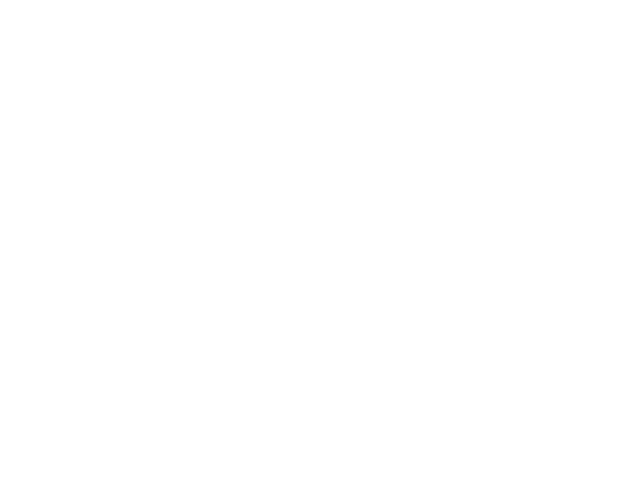

TypeError: 'numpy.float64' object is not iterable

In [28]:
%matplotlib notebook
for i in range(len(time_dependent_fit_coefficients[0])):
    plt.plot(t, time_dependent_fit_coefficients[0][i](t), label='coefficient $p_%i$' % (i))
    if i == 5: break

for i in range(len(models[0][0].fit_coefficients[0])):
    if 5 < i < 30: continue
    if i == 5: break
    plt.plot(t, [gamma[0](el) * models[0][0].fit_coefficients[0][i] for el in t], 
             label='original $p_%i$' % (i), linestyle='dashdot')
    plt.plot(t, [1. * models[0][0].fit_coefficients[0][i] for el in t], 
             label='original $p_%i$' % (i), linestyle='--', alpha=.1)
        
plt.title('fit-coefficients change over time $t$')
plt.xlabel('timestep $t$')
#plt.legend()
plt.show()

In [30]:
def convert_fit_coefficients_to_function(p, grade, dimension=3):
    assert(dimension == 3)
    if type(p) != np.ndarray: return print('Wrong coefficient type:', type(p), 'Expected numpy.ndarray.')

    #print('Polynominal of grade %i detected' % (grade))

    y_1_poly, y_2_poly, y_3_poly = cu.polynominal(dimension, grade)

    def func(y_1, y_2, y_3):
        res = 0
        for i in range(len(p)):
            res += p[i] * y_1 ** y_1_poly[i] * y_2 ** y_2_poly[i] * y_3 ** y_3_poly[i]
        return res

    return func

In [31]:
def func(t, x, p, q, r, grade):
    '''        |  |  |
               fit-coefficients,
               need to be converted to function each iteration
    '''
    fit_to_y_1 = convert_fit_coefficients_to_function(np.asarray([1. * el(t) for el in p]), grade)
    fit_to_y_2 = convert_fit_coefficients_to_function(np.asarray([1. * el(t) for el in q]), grade)
    fit_to_y_3 = convert_fit_coefficients_to_function(np.asarray([1. * el(t) for el in r]), grade)
    
    y = [0, 0, 0]
    
    y[0] = fit_to_y_1(x[0], x[1], x[2])[0]
    y[1] = fit_to_y_2(x[0], x[1], x[2])[0]
    y[2] = fit_to_y_3(x[0], x[1], x[2])[0]

    return y

In [ ]:
T = len(z_1_)
#T = 100

f = 1024
t = np.linspace(0, T, T * f)

ivp = [0, 0, 0]
index_start = 10
ivp[0] += z_1_[index_start]
ivp[1] += z_2_[index_start]
ivp[2] += z_3_[index_start]

sol, infodict = odeint(func, ivp, t, 
                       args=(time_dependent_fit_coefficients[0], 
                             time_dependent_fit_coefficients[1], 
                             time_dependent_fit_coefficients[2], grade), 
                       tfirst=True, full_output=True, printmessg=True)

In [ ]:
%matplotlib notebook
plt.plot(infodict['hu'])
plt.xlabel('timestep $t$')
plt.title('solver stepsize')
plt.show()

<IPython.core.display.Javascript object>


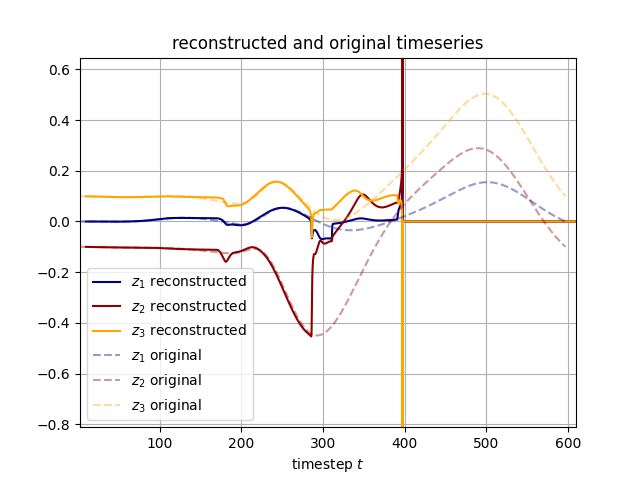

In [47]:
%matplotlib notebook
plt.plot(t + index_start, sol[:,0], label='$z_1$ reconstructed', c='navy')
plt.plot(t + index_start, sol[:,1], label='$z_2$ reconstructed', c='darkred')
plt.plot(t + index_start, sol[:,2], label='$z_3$ reconstructed', c='orange')

plt.plot(timesteps_ - 2, z_1_, linestyle='--', alpha=.4, label='$z_1$ original', c='navy')
plt.plot(timesteps_ - 2, z_2_, linestyle='--', alpha=.4, label='$z_2$ original', c='darkred')
plt.plot(timesteps_ - 2, z_3_, linestyle='--', alpha=.4, label='$z_3$ original', c='orange')


plt.title('reconstructed and original timeseries')
plt.xlabel('timestep $t$')
plt.grid()
plt.legend()
plt.show()